# Download Data

## Metadata
Using the [Sketchfab API](https://docs.sketchfab.com/data-api/v3/index.html#!/models/get_v3_models_uid_download), I queried the Sketchfab site and downloaded metadata describing 490 3D-models, by querying Sketchfab for existing 3D-model collections and compiling new collections on [my Sketchfab account](https://sketchfab.com/alvarosaurus/collections). The Sketchfab API provides data in JSON format.

In [5]:
import json
import requests
from requests.exceptions import RequestException
import pandas as pd
from pandas.io.json import json_normalize
import os

#Sketchfab API
#https://docs.sketchfab.com/data-api/v3/index.html#!/models/get_v3_models_uid_download
#(does not require an API key)
SKETCHFAB_API_URL = 'https://api.sketchfab.com/v3' # Sketchfab.com API URL


# Verterbrate anatomy skulls and crania
# Personal collection on my Sketchfab account
# https://sketchfab.com/alvarosaurus/collections/roman-pottery-training-set
SKULLS_AND_CRANIA_COLLECTION_URI = '29d45bdca4c84077932eaab5e2c244fe'


def list_models(next_cursor, collection_uri):
    """Download one page of json list of models."""
    endpoint = '{}/collections/{}/models?cursor={}'.format(SKETCHFAB_API_URL, collection_uri, next_cursor) # models in collection API endpoint (GET)        
    response = requests.get(endpoint)
    data = response.json()
    return data['results'], data['cursors']['next']

def read_collection(collection_uri):
    """List all models in collection, paginate, store models in data frame"""
    results, next_cursor = list_models(None, collection_uri)
    results_df = json_normalize(results)
    while(next_cursor):
        # get next paginated results, append to data frame
        results, next_cursor = list_models(next_cursor, collection_uri)
        results_df = results_df.append(json_normalize(results), sort=True) # parse json result
    return results_df

collections = [SKULLS_AND_CRANIA_COLLECTION_URI]

# List all models in all collections
collection_df = None
for collection in collections:
    result_df = read_collection(collection) # read collection from Sketchfab API
    if collection_df is None:
        collection_df = result_df
    else:
        collection_df = collection_df.append(result_df, sort=True)

# save the original data to file
collection_df.to_csv(os.path.join('data', 'downloaded_metadata.csv'), index=False)

Each 3D-model of an object can be characterized by a number of metadata attributes. I dropped those attributes which are not relevant to the project.

In [6]:
import pandas as pd
import os

# reload the original data
collection_df = pd.read_csv(os.path.join('data', 'downloaded_metadata.csv'), index_col=False)

# drop not relevant columns 
metadata_df = collection_df.drop(
    ['collectedAt', 'uid','publishedAt', 'createdAt', 'isDownloadable', 'isProtected', 'categories',
     'staffpickedAt', 'viewCount', 'likeCount', 'animationCount', 'soundCount', 'embedUrl', 'commentCount', 'isAgeRestricted', 'price', 
     'user.avatar.uid', 'user.avatar.uri', 'user.avatar.images', 'user.account', 'user.username', 'user.uri', 'user.uid', 
     'license.uri', 'license.requirements', 'license.label', 'license.slug', 'license.url', 'thumbnails.images', 'faceCount'], axis=1)

The attributes relevant to the project are:
* the name of the 3D model
* ideally a textual description of the object, written by a museum curator
* the API-URI where the 3D-model file can be downloaded
* a link to the 3D-model's preview page on Sketchfab
* the name of the museum, institution or organization that provided the digitized object
* a link to the providers page on Sketchfab
* the license of the 3D-model
* the number of vertices in the 3D-model
* tags added by the provider of the 3D-model describing the object (json)

### Object id's

I added a unique identifier to each object, extracted from the 3d-model's URI.

In [7]:
# Add a unique ID to each object
metadata_df['id'] = [uri.split('/')[-1] for uri in metadata_df.uri]

# drop duplicates
metadata_df = metadata_df.drop_duplicates(subset='uri', keep='first')

## Add taxonomic information
Add corresponding taxa: species, class order and kingdom. Retrieve these from Open Tree of Life.

In [1]:
import pandas as pd
import os

# Read csv file with model id and species
taxa_df = pd.read_csv(os.path.join('data', 'species.csv'))
# drop models with no species information
idx = taxa_df['species'].isna()
taxa_df = taxa_df[~idx]

taxa_df.shape

(439, 2)

In [2]:
from Tree_of_Life import Obtain_OTT_ID, Obtain_Lineage

taxon_phylum = []
taxon_class = []
taxon_order = []
taxon_family = []
taxon_genus = []
taxon_species = []

for i, row in taxa_df.iterrows():
    #print(row['species'])
    # get the Tree of Life id of the species
    ott = Obtain_OTT_ID().run(row['species'])
    # get the lineage of the species
    lineage = Obtain_Lineage().run(ott)
    if lineage is None or lineage['species'] is None:
        # no lineage found, add empty line, keep original species name
        taxon_phylum.append(None)
        taxon_class.append(None)
        taxon_order.append(None)
        taxon_family.append(None)
        taxon_genus.append(None)
        taxon_species.append(row['species'])
        continue
    # collect different rank taxa from lineage
    taxon_phylum.append(lineage['phylum']['name'])
    # classes are not always given, e.g. reptiles
    if lineage['class'] is None:
        taxon_class.append(None)
    else:
        taxon_class.append(lineage['class']['name'])
    taxon_order.append(lineage['order']['name'])
    taxon_family.append(lineage['family']['name'])
    taxon_genus.append(lineage['genus']['name'])
    taxon_species.append(lineage['species']['name'])

taxa_df['phylum'] = taxon_phylum
taxa_df['class'] = taxon_class
taxa_df['order'] = taxon_order
taxa_df['family'] = taxon_family
taxa_df['genus'] = taxon_genus
taxa_df['species'] = taxon_species
taxa_df.head()

id               species    phylum     class  \
0  22edbe4be11045b38b1db30e2c369cd7            Lynx rufus  Chordata  Mammalia   
1  8bfa68425cb945fd8c865874292ce5bf  Sylvilagus audubonii  Chordata  Mammalia   
2  b5909c4eefef402db9f8f8f9f9543a73    Lepus californicus  Chordata  Mammalia   
3  615e0a4cd42241a7a809f301434e3667   Bassariscus astutus  Chordata  Mammalia   
4  86b920ea7dfd40efa1470129234eca95  Conepatus leuconotus  Chordata  Mammalia   

        order       family        genus  
0   Carnivora      Felidae         Lynx  
1  Lagomorpha    Leporidae   Sylvilagus  
2  Lagomorpha    Leporidae        Lepus  
3   Carnivora  Procyonidae  Bassariscus  
4   Carnivora   Mephitidae    Conepatus

In [3]:
# drop entries where species was not found
idx = taxa_df['phylum'].isna()
taxa_df = taxa_df[~idx]

taxa_df.shape

(393, 7)

In [8]:
metadata_df = metadata_df.merge(taxa_df, on='id')

In [9]:
# save the original data to file
metadata_df.to_csv(os.path.join('data', 'metadata.csv'), index=False)

## Metadata EDA

### Objects by data provider

The 3D-models were contributed to Sketchfab by various institutions (tab. 2). 

In [10]:
counts = metadata_df['user.displayName'].value_counts() # user.displayName are the names of the data providers
# data providers with more than 10 objects 
idx = counts >= 10
# data providers with less than 10 objects
other_names = counts[~idx].keys()
idx_other = [name in other_names for name in metadata_df['user.displayName']]
metadata_df.loc[idx_other, 'user.displayName'] = 'Other (less than 10 models each)' # replace name by "other ..."
counts = metadata_df['user.displayName'].value_counts() # user.displayName are the names of the data providers
counts_df = pd.DataFrame(counts).reset_index(level=0).rename(columns={'index':'Provider', 'user.displayName': 'Object count in the dataset'})
idx_other = counts_df['Provider'] == 'Other (less than 10 models each)'
# put "other..." at the end of the data frame
other_counts = counts_df[idx_other]
counts_df.drop(other_counts.index, inplace=True)
counts_df = counts_df.append(other_counts)
counts_df

Provider  Object count in the dataset
0                          RISD Nature Lab                           84
1          Idaho Virtualization Laboratory                           77
2    Mammal Research Institute PAS, Poland                           69
3          University of Wyoming Libraries                           43
5                             Biodiversity                           26
6                               osuecampus                           26
7  University of Dundee Museum Collections                           17
8                                   WildCo                           13
4         Other (less than 10 models each)                           38

### Number of items per class

The number of items per class is imbalanced, as mammls are more represented than the other classes in the collection.

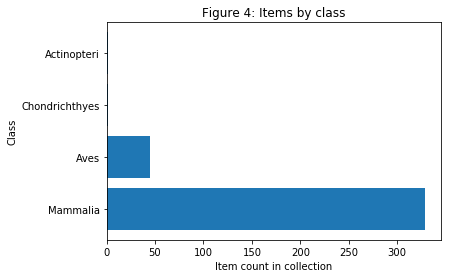

In [11]:
import matplotlib.pyplot as plt

# count items by class
counts = metadata_df['class'].value_counts()
# horizontal bar plot
plt.barh(counts.index, counts)
plt.xlabel('Item count in collection')
plt.ylabel('Class')
plt.title('Figure 4: Items by class')
plt.show();

### Mammal orders
There are 17 mammal orders represented in the data set. Carnivora (cats, dogs, seals etc.) is the most represented group. Artiodactyla, aka ungulates (pigs, antelopes, but als whales) is the second most represented group. The group distribution is imbalanced.

In [12]:
idx = metadata_df['class'] == 'Mammalia'
mammals_df = metadata_df[idx]

# count items by class
counts = mammals_df['order'].value_counts()
# horizontal bar plot
plt.barh(counts.index, counts)
plt.xlabel('Item count in collection')
plt.ylabel('Order')
plt.title('Figure 5: Mammals by order')
plt.show();

### _Carnivora_ by family

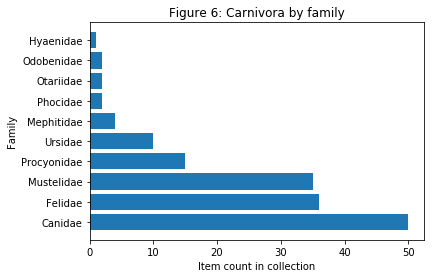

In [ ]:
idx = metadata_df['order'] == 'Carnivora'
carnivora_df = metadata_df[idx]

# count items by class
counts = carnivora_df['family'].value_counts()
# horizontal bar plot
plt.barh(counts.index, counts)
plt.xlabel('Item count in collection')
plt.ylabel('Family')
plt.title('Figure 6: Carnivora by family')
plt.show();

### _Felidae_ by genus

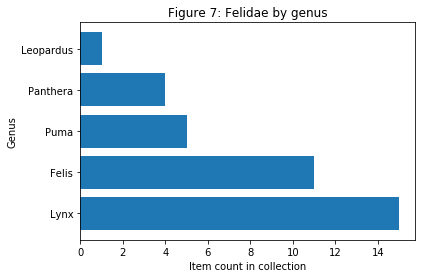

In [15]:
idx = metadata_df['family'] == 'Felidae'
canidae_df = metadata_df[idx]

# count items by class
counts = canidae_df['genus'].value_counts()
# horizontal bar plot
plt.barh(counts.index, counts)
plt.xlabel('Item count in collection')
plt.ylabel('Genus')
plt.title('Figure 7: Felidae by genus')
plt.show();

### _Canidae_ by genus

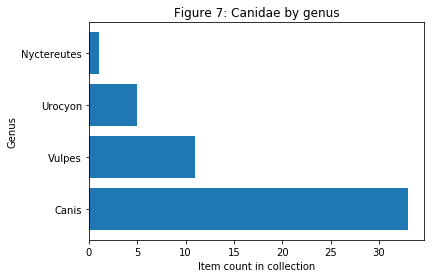

In [14]:
idx = metadata_df['family'] == 'Canidae'
canidae_df = metadata_df[idx]

# count items by class
counts = canidae_df['genus'].value_counts()
# horizontal bar plot
plt.barh(counts.index, counts)
plt.xlabel('Item count in collection')
plt.ylabel('Genus')
plt.title('Figure 8: Canidae by genus')
plt.show();

### _Canidae_ by species

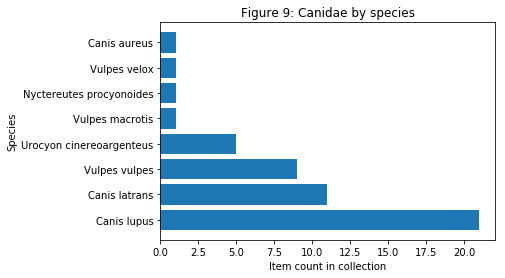

In [18]:
idx = metadata_df['family'] == 'Canidae'
canidae_df = metadata_df[idx]

# count items by class
counts = canidae_df['species'].value_counts()
# horizontal bar plot
plt.barh(counts.index, counts)
plt.xlabel('Item count in collection')
plt.ylabel('Species')
plt.title('Figure 9: Canidae by species')
plt.show();

### Classes per data provider

Additionally, each data provider has a different combinations of data classes: "The Royal Museums of Art and History" provides only data for the Bronze Age class, while "Global Digital Heritage" provides data for the Iron Age, Greek and Roman classes, etc.

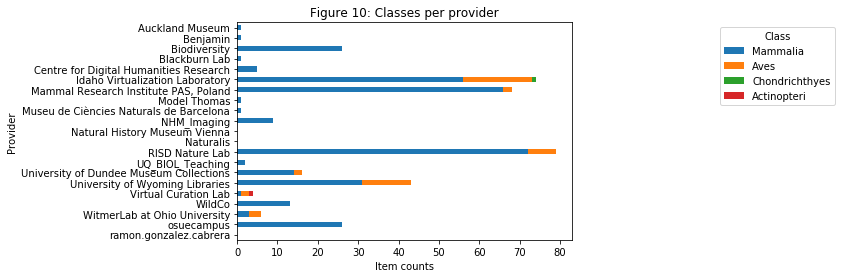

In [19]:
# for each provider, count items per period (class) 
classes_provider = []
for group in metadata_df.groupby('user.displayName'): # group by data provider (displayName is name of provider)
    counts = group[1].groupby('class')['class'].count()
    counts.name = group[0] 
    classes_provider.append(counts)
classes_provider = pd.DataFrame(classes_provider)

# make sure 'Other ...' is at the bottom
#other = classes_provider.loc['Other (less than 10 models each)']
#classes_provider.drop('Other (less than 10 models each)', inplace=True)
#classes_provider = classes_provider.append(other)

# reverse order of provider names top to bottom, stack by period
classes_provider.iloc[::-1].plot.barh(stacked=True) 
plt.title('Figure 10: Classes per provider')
plt.xlabel('Item counts')
plt.ylabel('Provider')
plt.legend(title='Class', loc='upper right', bbox_to_anchor=(1.8, 1))
plt.show();

### Distribution of vertices

The metadata includes information on the number of vertices in each 3D-model. 

In [20]:
# get the data to plot
x = metadata_df['vertexCount']

print(
    'The number of vertices per 3D-model ranges from {} to {}. \n\
The median is {:.0f}, the mean is {:.0f}, the standard deviation is {:.0f}, \n\
95% of the 3D-models have more than {:.0f} vertices.'.format(
    x.min(), x.max(), x.median(), x.mean(), x.std(),
    x.quantile(0.05)
))

The number of vertices per 3D-model ranges from 16663 to 3498001. 
The median is 499932, the mean is 600005, the standard deviation is 439953, 
95% of the 3D-models have more than 137502 vertices.


Looking at the distribution of vertex counts __by data provider__ using box plots (fig. 11A) shows that data has different variances for different data providers. This is most probably an artifact of the digitization process. Unfortunately, no detailed documentation about the process is available on the Sketchfab website.

Looking at the distribution of vertex counts __by taxonomical class__ (fig. 11B) shows that the data for the most represented taxonomical classes aves and Mammalia have similar variance.

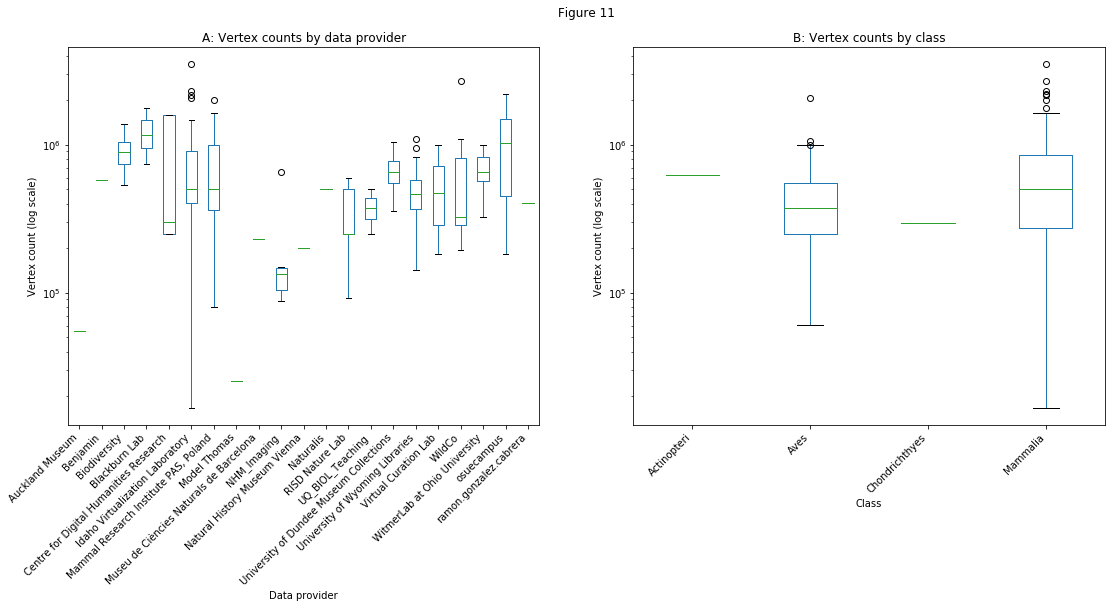

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# vertices by data provider
metadata_df.boxplot(ax=ax1, column='vertexCount', by='user.displayName', grid=False, rot=45, fontsize=10)
ax1.set_yscale("log")
ax1.set_xlabel('Data provider')
ax1.set_ylabel('Vertex count (log scale)')
ax1.set_title('A: Vertex counts by data provider')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')

# vertices by period
metadata_df.boxplot(ax=ax2, column='vertexCount', by='class', grid=False, rot=45, fontsize=10)
ax2.set_yscale("log")
ax2.set_xlabel('Class')
ax2.set_ylabel('Vertex count (log scale)')
ax2.set_title('B: Vertex counts by class')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')

fig.suptitle('Figure 11')
plt.show();

### Handling outliers

I examined the distribution of the number of vertices in the 3D-models. 95% of the 3D-models have more than 137502 vertices. I propose to discard 3D-models with fewer than 137502 vertices, and to sub sample 137502 vertices from 3D-models that have more vertices.

In [22]:
q95_vertices = metadata_df['vertexCount'].quantile(0.05)
idx = metadata_df['vertexCount'] >= q95_vertices
print('This will result in a dataset with {} objects, with {:.0f} vertices each.'.format(len(metadata_df[idx]), q95_vertices))

This will result in a dataset with 373 objects, with 137502 vertices each.


Discarding 3D-models with few vertices changes the distribution of the number of 3D-models in each class (classes are Bronze Age, Iron Age etc.). Removing outliers does not affect the imbalance between classes (fig. 9). 

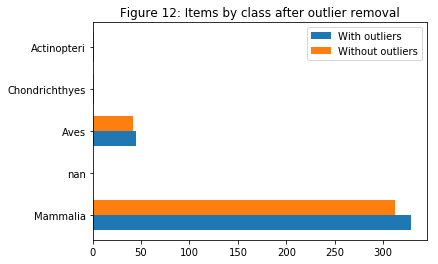

In [23]:
import numpy as np
import matplotlib.pyplot as plt

groups = metadata_df['class'].unique()
N = len(groups)

# count 3D-models before outlier removal
counts_all = metadata_df['class'].value_counts()
counts_all = counts_all.reindex(groups) # reverse order top to bottom

# count 3D-models after outlier removal
counts_q95 = metadata_df.loc[idx, 'class'].value_counts()
counts_q95 = counts_q95.reindex(groups) # reverse order top to bottom

# draw plot
fig, ax = plt.subplots()
ind = np.arange(N)    # the x locations for the groups
height = 0.35         # the width of the bars
ax.barh(ind, counts_all, height, label='With outliers')
ax.barh(ind + height, counts_q95, height, label='Without outliers')

ax.set_title('Figure 12: Items by class after outlier removal')
ax.set_yticks(ind + height / 2)
ax.set_yticklabels(groups)
ax.legend()
plt.show();

After removing outliers, I saved the cleaned dataset to disk in the file `data/metadata.csv`.

In [24]:
# save the cleaned data to file
metadata_df[idx].to_csv(os.path.join('data', 'metadata.csv'), index=False)

## 3D-models
I obtained 3D-models from the [Sketchfab website](https://sketchfab.com/3d-models/categories/cultural-heritage-history?date=week&features=downloadable&licenses=322a749bcfa841b29dff1e8a1bb74b0b&licenses=b9ddc40b93e34cdca1fc152f39b9f375&licenses=72360ff1740d419791934298b8b6d270&licenses=bbfe3f7dbcdd4122b966b85b9786a989&licenses=2628dbe5140a4e9592126c8df566c0b7&licenses=34b725081a6a4184957efaec2cb84ed3&licenses=7c23a1ba438d4306920229c12afcb5f9&licenses=783b685da9bf457d81e829fa283f3567&licenses=5b54cf13b1a4422ca439696eb152070d&sort_by=-likeCount). Sketchfab provides an [API](https://docs.sketchfab.com/data-api/v3/index.html#!/models/get_v3_models_uid_download) for querying and downloading 3D-models. I contacted Sketchfab to check if it would be alright to download a large number of 3D-models. They have been very supportive to my idea and I managed to use the API to download all the metadata and the 3D-models. 
The API requires a Sketchfab account and a key. The key is stored in the file `client_credentials.json` (not included in the submission). Please note that:
* 3D-models are large files. The project should require an estimated 10 GB of data, 5 GB for the downloaded files alone. I setup a virtual storage with 50 GB to hold the data for this project. Github recommends keeping projects under 5 GB. Therefore I will not be able to upload the 3D-models as such to the capstone repository, but only the preprocessed files. 
* the Sketchfab API has various download rate restrictions (per day, per hour, per minute), so that the download process has to be extended over a period of several days.

The downloaded 3D-models are stored as zip-compressed files on an external disk. This data is too large for GitHub.

In [25]:
import pandas as pd
import os

# reload the cleaned-up metadata
metadata_df = pd.read_csv(os.path.join('data', 'metadata.csv'), index_col=False)

# after attempting to download the models, it appears that some 3D-models are unavailable
unavailable = ['90ed2b7744134172bc8a24e37431ad39']
available_idx = [uid not in unavailable for uid in metadata_df.id]
metadata_df = metadata_df[available_idx]

print('There are {} 3D-models in the dataset.'.format(metadata_df.shape[0]))

There are 373 3D-models in the dataset.


Keeping only _Felidae_ and _Canidae_

In [30]:
idx = (metadata_df['family'] == 'Canidae') | (metadata_df['family'] == 'Felidae')
metadata_df = metadata_df[idx]

In [31]:
import json
import requests
import os
import time

# load credentials stored in local file
with open('client_credentials.json') as file:
    client_credentials = json.load(file)
API_TOKEN = client_credentials['api_token'] # Token from Sketchfab account

DOWNLOAD_DIR = '/mnt/Disk2/vertebrate_anatomy_models' # Folder to store the downloaded files
DOWNLOAD_DELAY = 20 # seconds, 200 / hour API rate limit
DOWNLOAD_ENDPOINT = 'https://api.sketchfab.com/v3/models/{}/download' # API endpoint

# HTTP request headers
headers = {'Authorization': 'Token {}'.format(API_TOKEN)} # Authorization method used
headers.update({'Content-Type': 'application/json'}) # http content type of the request

def download_data(uid):
    """
    Downloads a 3D-model from Sketchfab, saves it to a zipped file.
    @param: uid unique id of the model
    @raises: RequestException, e.g. API limit exceeded
    """
    # get the download url of the model
    # this url is only valid for a few minutes
    r = requests.get(
        DOWNLOAD_ENDPOINT.format(uid),
        headers = headers
    )
    r.raise_for_status() # throw exception if request status is not OK
    model_link = json.loads(r.text)
    url = model_link['gltf']['url'] # download url of the model

    # download the 3D-model, save it to file
    r = requests.get(url)
    with open(filename,'wb') as output_file:
        output_file.write(r.content)
            

try:
    # loop through the metadata table and download each 3D-model
    total = len(metadata_df)
    counter = 1
    verbose = False
    for model_uid in metadata_df['id']:
        filename = os.path.join(DOWNLOAD_DIR, '{}.zip'.format(model_uid)) # file to save the 3D-model
        if os.path.isfile(filename): # check that the file hasn't been downloaded already
            if verbose:
                print('File {} already exists'.format(filename))
        else:
            print('Downloading model {} ({}/{})'.format(model_uid, counter, total))
            download_data(model_uid) # download and save the 3D-model
            time.sleep(DOWNLOAD_DELAY) # don't hit the API too hard
        counter += 1

# Downloads may fail, typically when API limit exceeded
except requests.exceptions.RequestException:
    print('Download failed for 3D-model: {}'.format(model_uid))


In [32]:
print('The output of this step is: a folder with {} compressed files of 3D-models.'.format(
    len([
        name for name in os.listdir(DOWNLOAD_DIR) 
        if os.path.isfile(os.path.join(DOWNLOAD_DIR, name))
    ])
))

The output of this step is: a folder with 149 compressed files of 3D-models.
